<a href="https://colab.research.google.com/github/adityaprakash81480/PROJECTS/blob/main/FRS_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#create a kaggle folder
#copy the kaggle.json to folder created
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
# permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# to list all datasets in kaggle
!kaggle datasets list

ref                                                           title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                         Spotify and Youtube                                9MB  2023-03-20 15:43:25           3915        153  1.0              
ashishraut64/global-methane-emissions                         Global Emissions.                                 31KB  2023-03-27 09:02:51           1117         34  1.0              
thitiwat/top-100-most-expensive-football-transfers            ⚽ Top 100 most expensive football transfers        2KB  2023-03-27 04:06:28            660         26  1.0              
davidms8/product-sales-detail                                 Product Sales - Detail 

In [ ]:
!kaggle datasets download -d yasserh/avengers-faces-dataset

 98% 88.0M/89.6M [00:06<00:00, 20.7MB/s]
100% 89.6M/89.6M [00:06<00:00, 14.0MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("avengers-faces-dataset.zip",'r')
zip_ref.extractall()
zip_ref.close()


## Importing the basic libraries


In [ ]:
import cv2
import math
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings 
warnings.filterwarnings('ignore')


## Reading images

In [ ]:
# Defining the path for train and test images

Train_dir = pathlib.Path('/content/images/train')
Test_dir = pathlib.Path('//content/images/test')
Val_dir = pathlib.Path('/content/images/val')

image_count_train = len(list(Train_dir.glob('*/*.png')))
print("Training Samples ---> ",image_count_train)

image_count_test = len(list(Test_dir.glob('*/*.png')))
print("Testing Samples ---> ",image_count_test)

image_count_val = len(list(Val_dir.glob('*/*.png')))
print("Testing Samples ---> ",image_count_val)

Training Samples --->  274
Testing Samples --->  60
Testing Samples --->  60


### Defining constants

In [ ]:


random_seed=123
batch_size = 32
img_height = 180
img_width = 180

### Training Set

In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(Train_dir,
                                                               seed=random_seed,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 274 files belonging to 5 classes.


### Testing Set

In [ ]:

test_ds = tf.keras.preprocessing.image_dataset_from_directory(Test_dir,
                                                               seed=random_seed,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 60 files belonging to 5 classes.


### Validation Set

In [ ]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(Val_dir,
                                                               seed=random_seed,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 60 files belonging to 5 classes.


## Exploring the dataset

In [ ]:
# Listing of all the classes

class_names = train_ds.class_names
class_map={}
name_class_map={"chris_evans":"Chris_Evans", "chris_hemsworth":"Chris_Hemsworth", "mark_ruffalo":"Mark_Ruffalo", 
"robert_downey_jr":"Robert_Downey_Jr", "scarlett_johansson":"Scarlett_Johansson"}

for i in range(len(class_names)):
    class_map[i]=class_names[i]
class_map

{0: 'chris_evans',
 1: 'chris_hemsworth',
 2: 'mark_ruffalo',
 3: 'robert_downey_jr',
 4: 'scarlett_johansson'}

###Visualizing the Data Classes Distribution

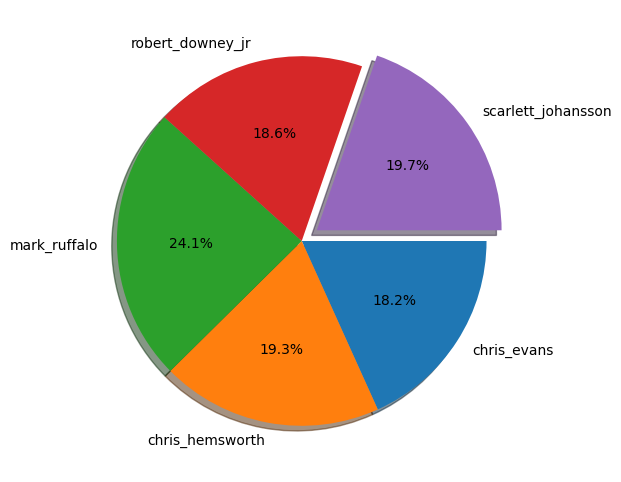

In [ ]:


class_count = []
for i in range(len(class_names)):
    class_count.append(len(list(Train_dir.glob('{}/*.png'.format(class_names[i])))))

    
plt.pie(class_count, shadow=True, startangle=0, explode=[0,0,0,0,0.1], autopct='%1.1f%%', counterclock=False, labels=train_ds.class_names)
#, labels=class_map.values())
plt.show()


### Visualising the batch of image dataset

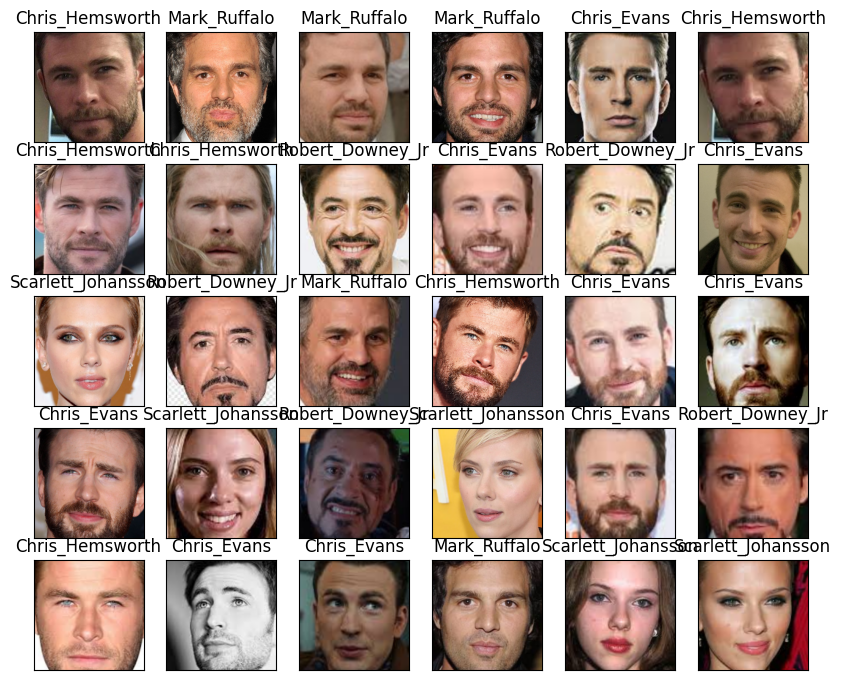

In [ ]:


plt.figure(figsize=[10,10])
for image, label in train_ds.take(1): # get the first batch
    for e,i in enumerate(image):
        if e<30:
            plt.subplot(6,6,e+1)
            plt.imshow(i.numpy().astype('uint8'))
            plt.title(name_class_map[class_map[label[e].numpy()]])
            plt.xticks([])
            plt.yticks([])
plt.show()

###  Staging the Dataset(configure the dataset for performance)

In [ ]:


AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## DL model training

In [ ]:
# Develop a sequential model using tensorflow keras

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width,3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu" ),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu" ),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu" ),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
# Training the model

chkpt = ModelCheckpoint('checkpoints/best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.01)

epochs=25
history_1 = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[es, chkpt])

Epoch 1/25
7/9 [======================>.......] - ETA: 0s - loss: 1.6912 - accuracy: 0.1714
Epoch 1: val_loss improved from inf to 1.59491, saving model to checkpoints/best_model.h5
9/9 [==============================] - 15s 251ms/step - loss: 1.6716 - accuracy: 0.1934 - val_loss: 1.5949 - val_accuracy: 0.2167
Epoch 2/25
8/9 [=========================>....] - ETA: 0s - loss: 1.6001 - accuracy: 0.2645
Epoch 2: val_loss improved from 1.59491 to 1.55980, saving model to checkpoints/best_model.h5
9/9 [==============================] - 1s 123ms/step - loss: 1.5971 - accuracy: 0.2664 - val_loss: 1.5598 - val_accuracy: 0.5000
Epoch 3/25
9/9 [==============================] - ETA: 0s - loss: 1.5259 - accuracy: 0.3759
Epoch 3: val_loss improved from 1.55980 to 1.36436, saving model to checkpoints/best_model.h5
9/9 [==============================] - 1s 85ms/step - loss: 1.5259 - accuracy: 0.3759 - val_loss: 1.3644 - val_accuracy: 0.4833
Epoch 4/25
9/9 [==============================] - ETA: 0s -

### Visualizing the model performance

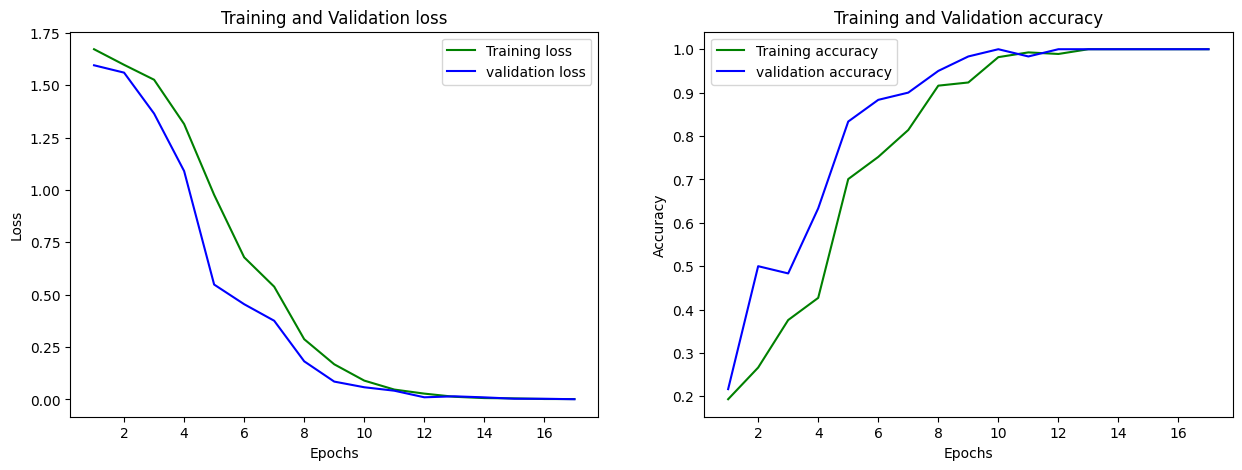

In [ ]:


acc_train = history_1.history['accuracy']
acc_val = history_1.history['val_accuracy']

loss_train = history_1.history['loss']
loss_val = history_1.history['val_loss']

epochs = range(1,len(loss_train)+1)
plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###  Loading the saved model from checkpoint

In [ ]:


saved_model = tf.keras.models.load_model('checkpoints/best_model.h5')
saved_model

### Reading the sample image file

In [ ]:

import urllib
urllib.request.urlretrieve("https://raw.githubusercontent.com/Masterx-AI/Project_Face_Recognition/main/robert.jpg", "robert.jpg")
urllib.request.urlretrieve("https://raw.githubusercontent.com/Masterx-AI/Project_Face_Recognition/main/face.xml", "face.xml")

img = cv2.imread('robert.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



###  Plotting the image

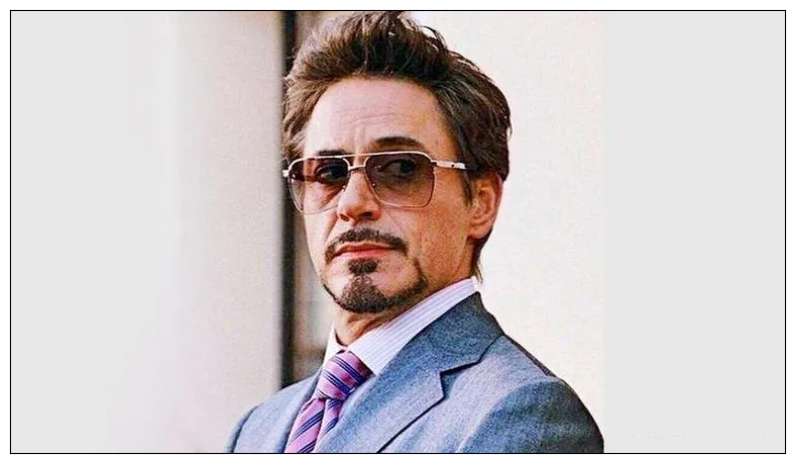

In [ ]:

def plot_image(img, cmap=None): 
    plt.imshow(img, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    
plot_image(img)
plt.show()

###  Converting the image to grayscale

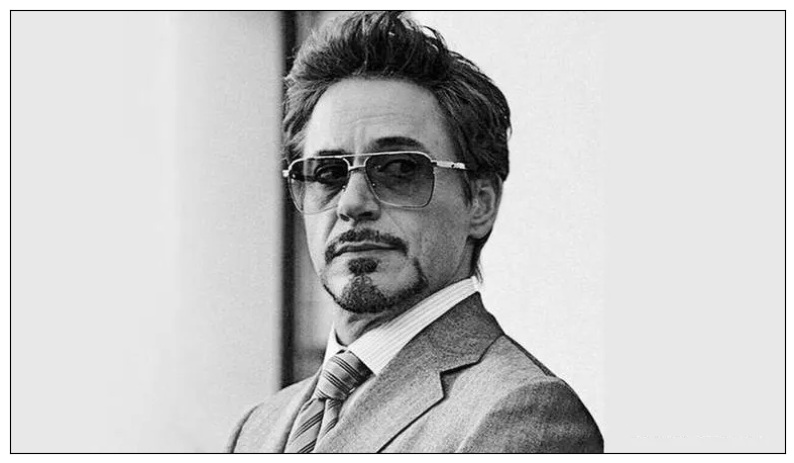

In [ ]:

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plot_image(gray, cmap='gray')
plt.show()

###  Implementing the Cascade Classifier

In [ ]:


face_cascade = cv2.CascadeClassifier('face.xml')

faces_rect = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10)

print(f'Number of face ===> {len(faces_rect)}')

Number of face ===> 1


### Plotting the area of face detection

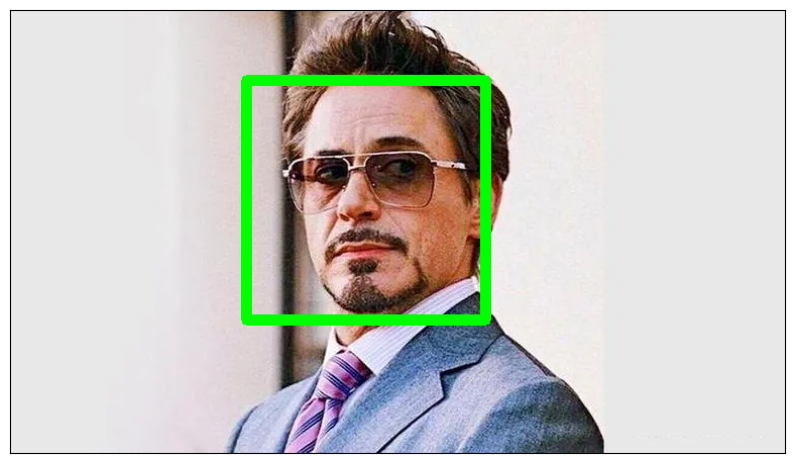

In [ ]:


for (x,y,w,h) in faces_rect:
    cropped = img[y:y+h, x:x+w].copy()
    cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), thickness=10)
    
plot_image(img)

### Prediction(Individual)

1/1 [==============================] - 0s 212ms/step


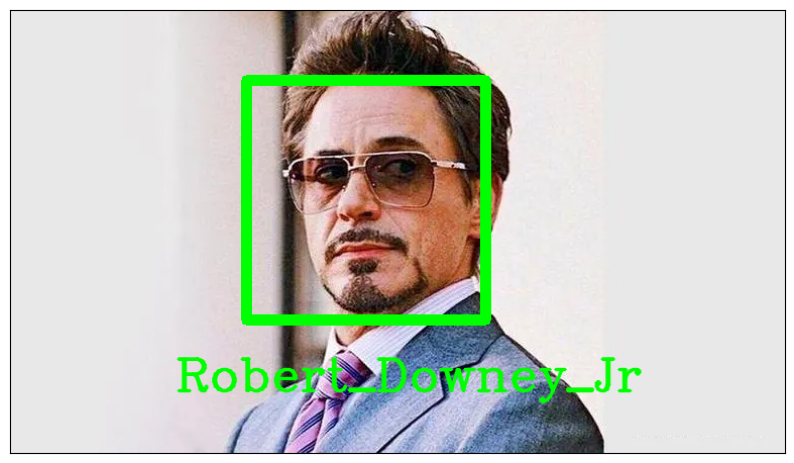

In [ ]:

img_2 = img.copy()
cropped = cv2.resize(cropped, (img_height, img_width))
final_img = np.expand_dims(cropped, axis=0)
                           
prediction = saved_model.predict(final_img)
predicted_value = np.argmax(prediction)
predicted_label = name_class_map[class_map[predicted_value]]

cv2.putText(img_2, predicted_label, (x-70,y+h+70), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0,255,0), 2, cv2.LINE_AA)
    
plot_image(img_2)

## Batch Prediction(Visualizing a batch of image dataset)

1/1 [==============================] - 0s 22ms/step


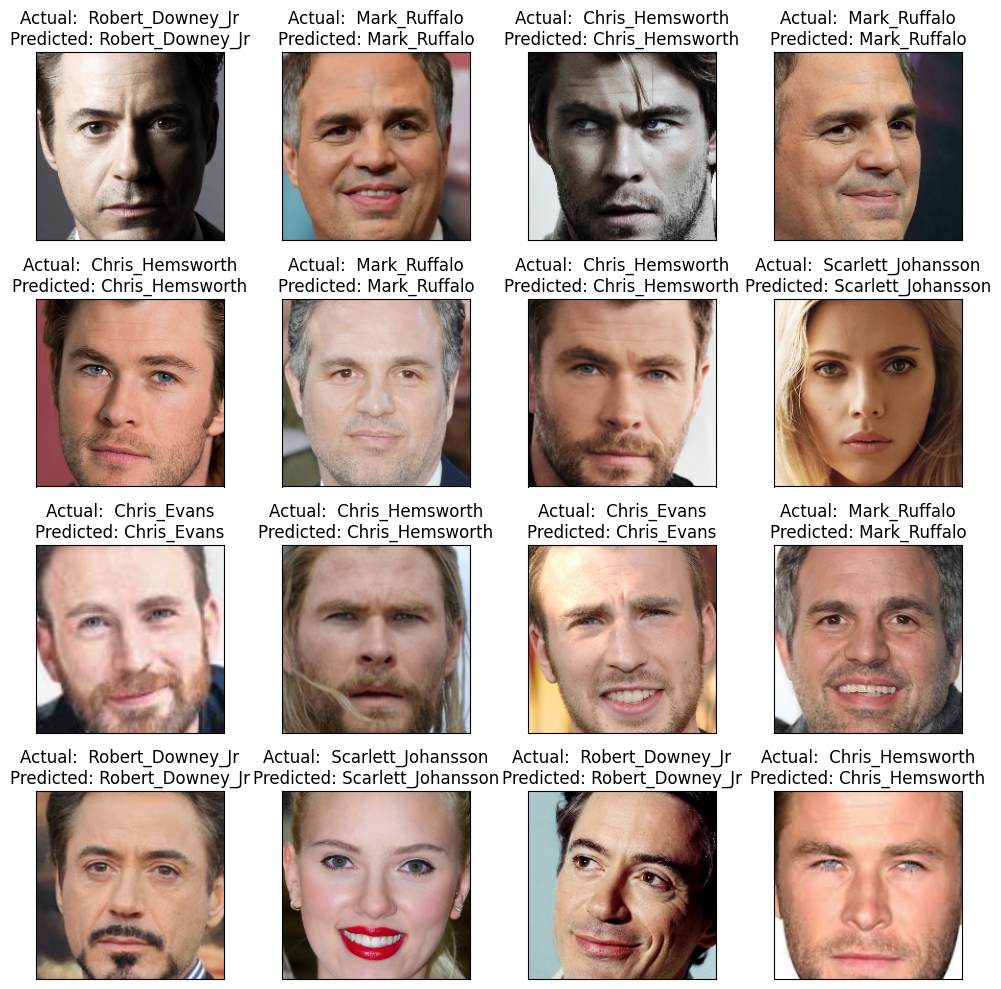

In [ ]:


test_batch = [(x, y) for (x,y) in val_ds.take(1)] # loading 1 batch of data
image, label = test_batch[0][0], test_batch[0][1]

prediction = saved_model.predict(image)
prediction = np.argmax(prediction, axis=1)


plt.figure(figsize=[10,10])
for e in range(16):
    plt.subplot(4,4,e+1)
    plt.imshow(image[e].numpy().astype('uint8'))
    actual_label = name_class_map[class_map[label[e].numpy()]]
    prediction = saved_model.predict(np.expand_dims(image[e], axis=0))
    predicted_label = name_class_map[class_map[np.argmax(prediction)]]
    #predicted_label = np.argmax(saved_model.predict(image))
    plt.title('Actual:  {}\nPredicted: {}'.format(actual_label, predicted_label))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Finally Done..!!
